In [23]:
import pyemma
pyemma.__version__
import numpy as np
import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mpl
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
import shutil
import os
from pyemma.util.contexts import named_temporary_file
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
#import torch
import indices
from indices.base import BaseComparisons as bc
from indices.faith import Faith as Fai
import scipy.cluster.hierarchy as shc
from matplotlib import gridspec
from matplotlib import pyplot
import mdtraj
import pandas  as pd
import seaborn as sns

In [ ]:
Threshold = 0.6
traj_file = '../../native_0/short_traj_00.dcd'
traj = md.load_dcd(traj_file,top='../../native_0/topol.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = list(range(0,topfile.n_residues))[0:27]+list(range(0,topfile.n_residues))[56:81]+list(range(0,topfile.n_residues))[116:125]+list(range(0,topfile.n_residues))[136:147]
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load(traj_file, features=feat)

In [ ]:
traj_all = md.load_dcd('../../native_0/trajectory.00.dcd',top='../../native_0/topol.pdb')
topfile=traj_all.top
all_C=topfile.select("type C")
native_pdb = md.load_pdb('../../native_0/a.pdb')
for i in range(10,12):
    if i < 10:
        traj_all += md.load_dcd('../../native_0/trajectory.0{}.dcd'.format(i),top='../../native_0/topol.pdb')
    else:
        traj_all += md.load_dcd('../../native_0/trajectory.{}.dcd'.format(i),top='../../native_0/topol.pdb')
rmsd=md.rmsd(traj_all,native_pdb,atom_indices=all_C)
plt.scatter(range(len(rmsd)),list(rmsd),marker='.')
plt.ylim(0,1)
traj_all[rmsd>0.6][[np.random.randint(0,len(traj_all[rmsd>0.6]),1000)]].save('../../native_0/unbind_samples.dcd')

In [ ]:
traj_all = md.load_dcd('../../native_0/native_samples.dcd',top='../../native_0/topol.pdb')
files = ['../../native_0/unbind_samples.dcd','../../native_0/middle_samples.dcd']
for i in files:
    traj_all+=md.load_dcd(i,top='../../native_0/topol.pdb')
traj_all[[np.random.randint(0,len(traj_all),1000)]].save_dcd('../../native_0/test_samples.dcd')

In [4]:
Threshold = 0.7
traj_file = '../../native_0/test_samples.dcd'
traj = md.load_dcd(traj_file,top='../../native_0/topol.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
all_C=topfile.select("type C")
residues = list(range(0,topfile.n_residues))[0:27]+list(range(0,topfile.n_residues))[56:81]+list(range(0,topfile.n_residues))[116:125]+list(range(0,topfile.n_residues))[136:147]
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load(traj_file, features=feat)

In [5]:

all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')


###calculate similarity
simi = all_c[:,0]+all_c[:,2]
###try Faith
disimi = all_c[:,1]
denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
w_p = simi/denominate
simi_matrix = np.zeros((len(inp),len(inp)))
indices = np.triu_indices(len(inp),k=1)
indices = (indices[1],indices[0])
simi_matrix[indices] = simi
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (499500, 3)
step 0 time = 7.85 s
final matrix shape =  (1000, 1000)
total time = 7.92 s


In [6]:
all_start=time.time()
df = pd.DataFrame(simi_matrix,columns=pd.MultiIndex.from_tuples([('{}'.format(i),'{}'.format(i)) for i in range(1,len(inp)+1)],names=['cluster', 'frame']))
inp_copy=inp
dic={}
hie_tree=[]
dentrom=[]
while df.shape[0] > 2:
    ###update df
    frame_column=[i[1] for i in df.columns.to_list()]
    hie_tree.append(frame_column)
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1s

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]][1].split(',') ]
    delete_cluster_row=[int(i) for i in df.columns[del_index[0]][0].split(',')]
    delete_column=[int(i) for i in df.columns[del_index[1]][1].split(',') ]
    delete_cluster_column=[int(i) for i in df.columns[del_index[1]][0].split(',')]
    dentrom.append([*delete_cluster_column,*delete_cluster_row])

    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1s
    insert_cluster_index='{}'.format(2*len(inp) - df.shape[0]+1)
    df.drop(columns=[('{}'.format(delete_cluster_column)[1:-1],'{}'.format(delete_column)[1:-1]),('{}'.format(delete_cluster_row)[1:-1],'{}'.format(delete_row)[1:-1])],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1s

    ###get temp inp
   # print(df.columns)
    frame_column=[i[1] for i in df.columns.to_list() ]
    columns=[[int(d) for d in [*i.split(',')]] for i in frame_column]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
    
    for i in temp_inp:
        compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        temp_w_sim.append(compare.total_w_sim)         ###1s

#     temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 100 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge {} clusters time ='.format(df.shape[0]), round(all_time,2),'s')
    df.insert(loc=0, column=(insert_cluster_index,insert_index), value=temp_w_sim)

    dic[insert_index]=max_value
#     temp_end = time.time() 
#     temp_time = temp_end - temp_start           
#     print('step {} time = '.format(df.shape[0]),temp_time)  ###1s
last_two = [int(i[0]) for i in df.columns.to_list()]
dentrogram = np.vstack(dentrom)-np.ones((1,2))
values = np.max(simi_matrix)-np.array([*dic.values()],ndmin=2)+2
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
tree = np.hstack((dentrogram,values.T,num_frames.T))
tree = np.vstack((tree, [[last_two[0]-1,last_two[1]-1,np.max(simi_matrix)-df.to_numpy()[1][0],len(inp)]]))

merge 900 clusters time = 10.1 s
merge 800 clusters time = 19.12 s
merge 700 clusters time = 28.01 s
merge 600 clusters time = 35.91 s
merge 500 clusters time = 42.81 s
merge 400 clusters time = 49.09 s
merge 300 clusters time = 54.55 s
merge 200 clusters time = 59.51 s
merge 100 clusters time = 64.42 s


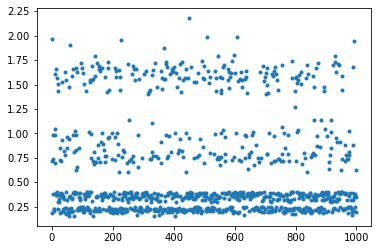

In [7]:
native_pdb = md.load_pdb('../../native_0/a.pdb')
traj_random = md.load_dcd('../../native_0/test_samples.dcd',top='../../native_0/topol.pdb')
rmsd=md.rmsd(traj_random,native_pdb,atom_indices=all_C)
plt.scatter(range(len(rmsd)),list(rmsd),marker='.')

In [8]:
def plot_simi_threshold(tree,p,min_simi,save=False):
    plt.figure(figsize=(20, 8))
    dend = shc.dendrogram(tree,p=p,truncate_mode='lastp')
    plt.axhline(y=70, color='r', linestyle='-')
    plt.xlabel('Num_samples')
    plt.ylabel('Simi_value')
    if save:
        plt.savefig('simi_threshold_tree.png')
def plot_test_result(true_rmsd,hie_tree,cluster_step,save=False):
    colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
    fig, ax = plt.subplots(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    test_rmsd = [[true_rmsd[i] for i in label_index[d]] for d in range(len(label_index))]
    for index,i in enumerate(test_rmsd):
        ax0.scatter(label_index[index],i,marker='.',color=colors[index])
    percentage=[len(i)/len(true_rmsd) for i in test_rmsd]
    sum_percentage = [0.0]+[sum(percentage[:i]) for i in range(1,len(percentage))]+[1.0]
    ax0.set_xlabel('Sample')
    ax0.set_ylabel('RMSD')
    cmap = mpl.colors.ListedColormap(colors[:len(test_rmsd)])
    print(colors[:len(test_rmsd)])
    norm = mpl.colors.BoundaryNorm(sum_percentage, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=sum_percentage,
                                    ticks=sum_percentage+[1.0],
                                    spacing='proportional')
    cb2.set_label('Cluster samples ratio')
    if save:
        plt.savefig('simi_threshold_tree.png')
    return label_index

['grey', 'purple', 'blue', 'green', 'orange', 'red', 'black', 'brown', 'navy', 'indigo', 'cyan', 'teal', 'violet', 'royalblue']


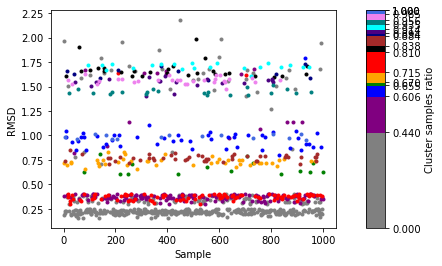

In [26]:
label = plot_test_result(rmsd,hie_tree,-12,save=False)

In [14]:
traj_random[label[0]].save('check_native.dcd')

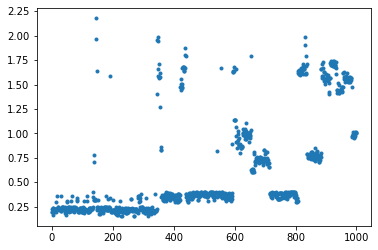

In [27]:
label_concate = np.concatenate(label)
traj_cluster=traj[label_concate]
cluster_rmsd=md.rmsd(traj_cluster,native_pdb,atom_indices=all_C)
plt.scatter(range(len(cluster_rmsd)),list(cluster_rmsd),marker='.')

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
(500500,)


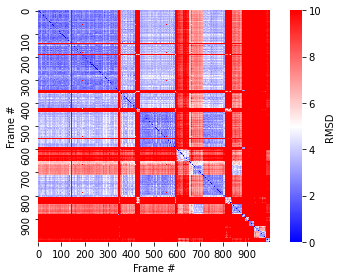

In [28]:
rmsd_2d=np.zeros((len(traj_cluster),len(traj_cluster)))
upper_indices = np.triu_indices(len(traj_cluster),k=0)
lower_indices = (upper_indices[1],upper_indices[0])
r2d = []
for i in range(len(traj_cluster)):
    r2d.append(md.rmsd(traj_cluster[i:],traj_cluster[i],atom_indices=all_C))
    if i % 50 == 0:
        print(i)
print(np.concatenate(r2d).shape)
rmsd_2d[lower_indices] = np.concatenate(r2d)
rmsd_2d[upper_indices] = np.concatenate(r2d)
rmsd_2d[lower_indices] = np.concatenate(r2d)
sns.heatmap(rmsd_2d*10,square=True,xticklabels=100,yticklabels=100,cmap='bwr',cbar_kws={'label':'RMSD'},vmin=0,vmax=10)
#plt.plot(range(1000),range(1000),'-.',color='k',linewidth=2)
plt.xlabel("Frame #")
plt.ylabel("Frame #")
ax = plt.gca()
ax.tick_params(direction='out')
plt.tight_layout()